In [ ]:
import matplotlib.pyplot as plt
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
plt.style.use('seaborn-v0_8-white')

#Time Series with LSTM networks. Multivariate Multi-Step

##1. The problem to be solved.

Create and train a LSTM Network using the multivariate + multi-step approach:

We take as input of the model 16 covariates available in the dataset (hence the term multivariate) and at the output we will try to predict 3 hours of the 16 variables into the future (hence the term multi-step).

Specifically we will have to modify in our code:

1. **Pre-processing** to create the supervised dataset with the required number of covariates at the input of the model.
2. **The LSTM Network**, which instead of a single one will now have to accept 16 input variables (each with a record of 48 blocks of 30 minutes).

##2. Reading of the dataset

The data sample corresponds to the period from 01/Mar/2023 to 31/Jul/2023.


In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Flatten, GRU
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import tensorflow as tf


# df1 = pd.read_csv('cpu_percent_results_2.csv', usecols=['beginTimeSeconds', 'CPU percent'])
# df2 = pd.read_csv('uptime_results_2.csv', usecols=['Uptime'])
# df3 = pd.read_csv('tx_rx_results_2.csv',
#                   usecols=['Rx packets', 'Tx packets'])
# df4 = pd.read_csv('nb_np_results_2.csv',
#                   usecols=['NetBytes In', 'NetBytes Out', 'NetPackets In', 'NetPackets Out'])
# df5 = pd.read_csv('disk_memory_results_2.csv',
#                   usecols=['Disk read/s', 'Disk write/s', 'Free Disk', 'Free Memory', 'Used Disk',
#                            'Used Memory'], dtype='str')
# df6 = pd.read_csv('disk_percent_results_2.csv', usecols=['Disk Used percent'])
# df7 = pd.read_csv('memory_percent_results_2.csv', usecols=['Memory Used percent'])

# df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=1)
# df = df2.copy()
# df.head()

In [ ]:
df = pd.read_csv('data (1).csv', index_col=0, parse_dates=['beginTimeSeconds'])
df.head()

,CPU percent,Uptime,Rx packets,Tx packets,NetBytes In,NetBytes Out,NetPackets In,NetPackets Out,Disk read/s,Disk write/s,Free Disk,Free Memory,Used Disk,Used Memory,Disk Used percent,Memory Used percent
beginTimeSeconds,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,35.89,99.4234,1800,1800,15,15,15,15,14.12,44.97,76.93,3.75,43.86,4.44,27.57,54.23
2023-03-01 00:30:00,36.57,99.4233,1800,1800,15,15,15,15,5.19,41.19,76.94,3.76,43.84,4.43,27.55,54.14
2023-03-01 01:00:00,37.94,99.4232,1800,1800,15,15,15,15,23.64,70.99,77.00,3.77,43.78,4.41,27.52,53.91
2023-03-01 01:30:00,37.40,99.4231,1800,1800,15,15,15,15,5.25,38.45,77.00,3.78,43.79,4.41,27.52,53.86
2023-03-01 02:00:00,38.08,99.4230,1800,1800,15,15,15,15,9.42,43.94,77.01,3.76,43.77,4.43,27.51,54.11


In [ ]:
df.shape

(7344, 16)

In [ ]:
new_order_columns = [
    'Free Memory',
    'Used Memory',
    'Free Disk',
    'Used Disk',
    'Disk read/s',
    'Disk write/s',
    'NetBytes In',
    'NetBytes Out',
    'NetPackets In',
    'NetPackets Out',
    'Rx packets',
    'Tx packets',
    'CPU percent',
    'Memory Used percent',
    'Disk Used percent',
    'Uptime',
]
df = df[new_order_columns]

In [ ]:
# df['beginTimeSeconds'] = pd.to_datetime(df['beginTimeSeconds'], unit='s')
# df = df.set_index('beginTimeSeconds')

In [ ]:
df.shape # a total of 7344 data with 16 variables

(7344, 16)

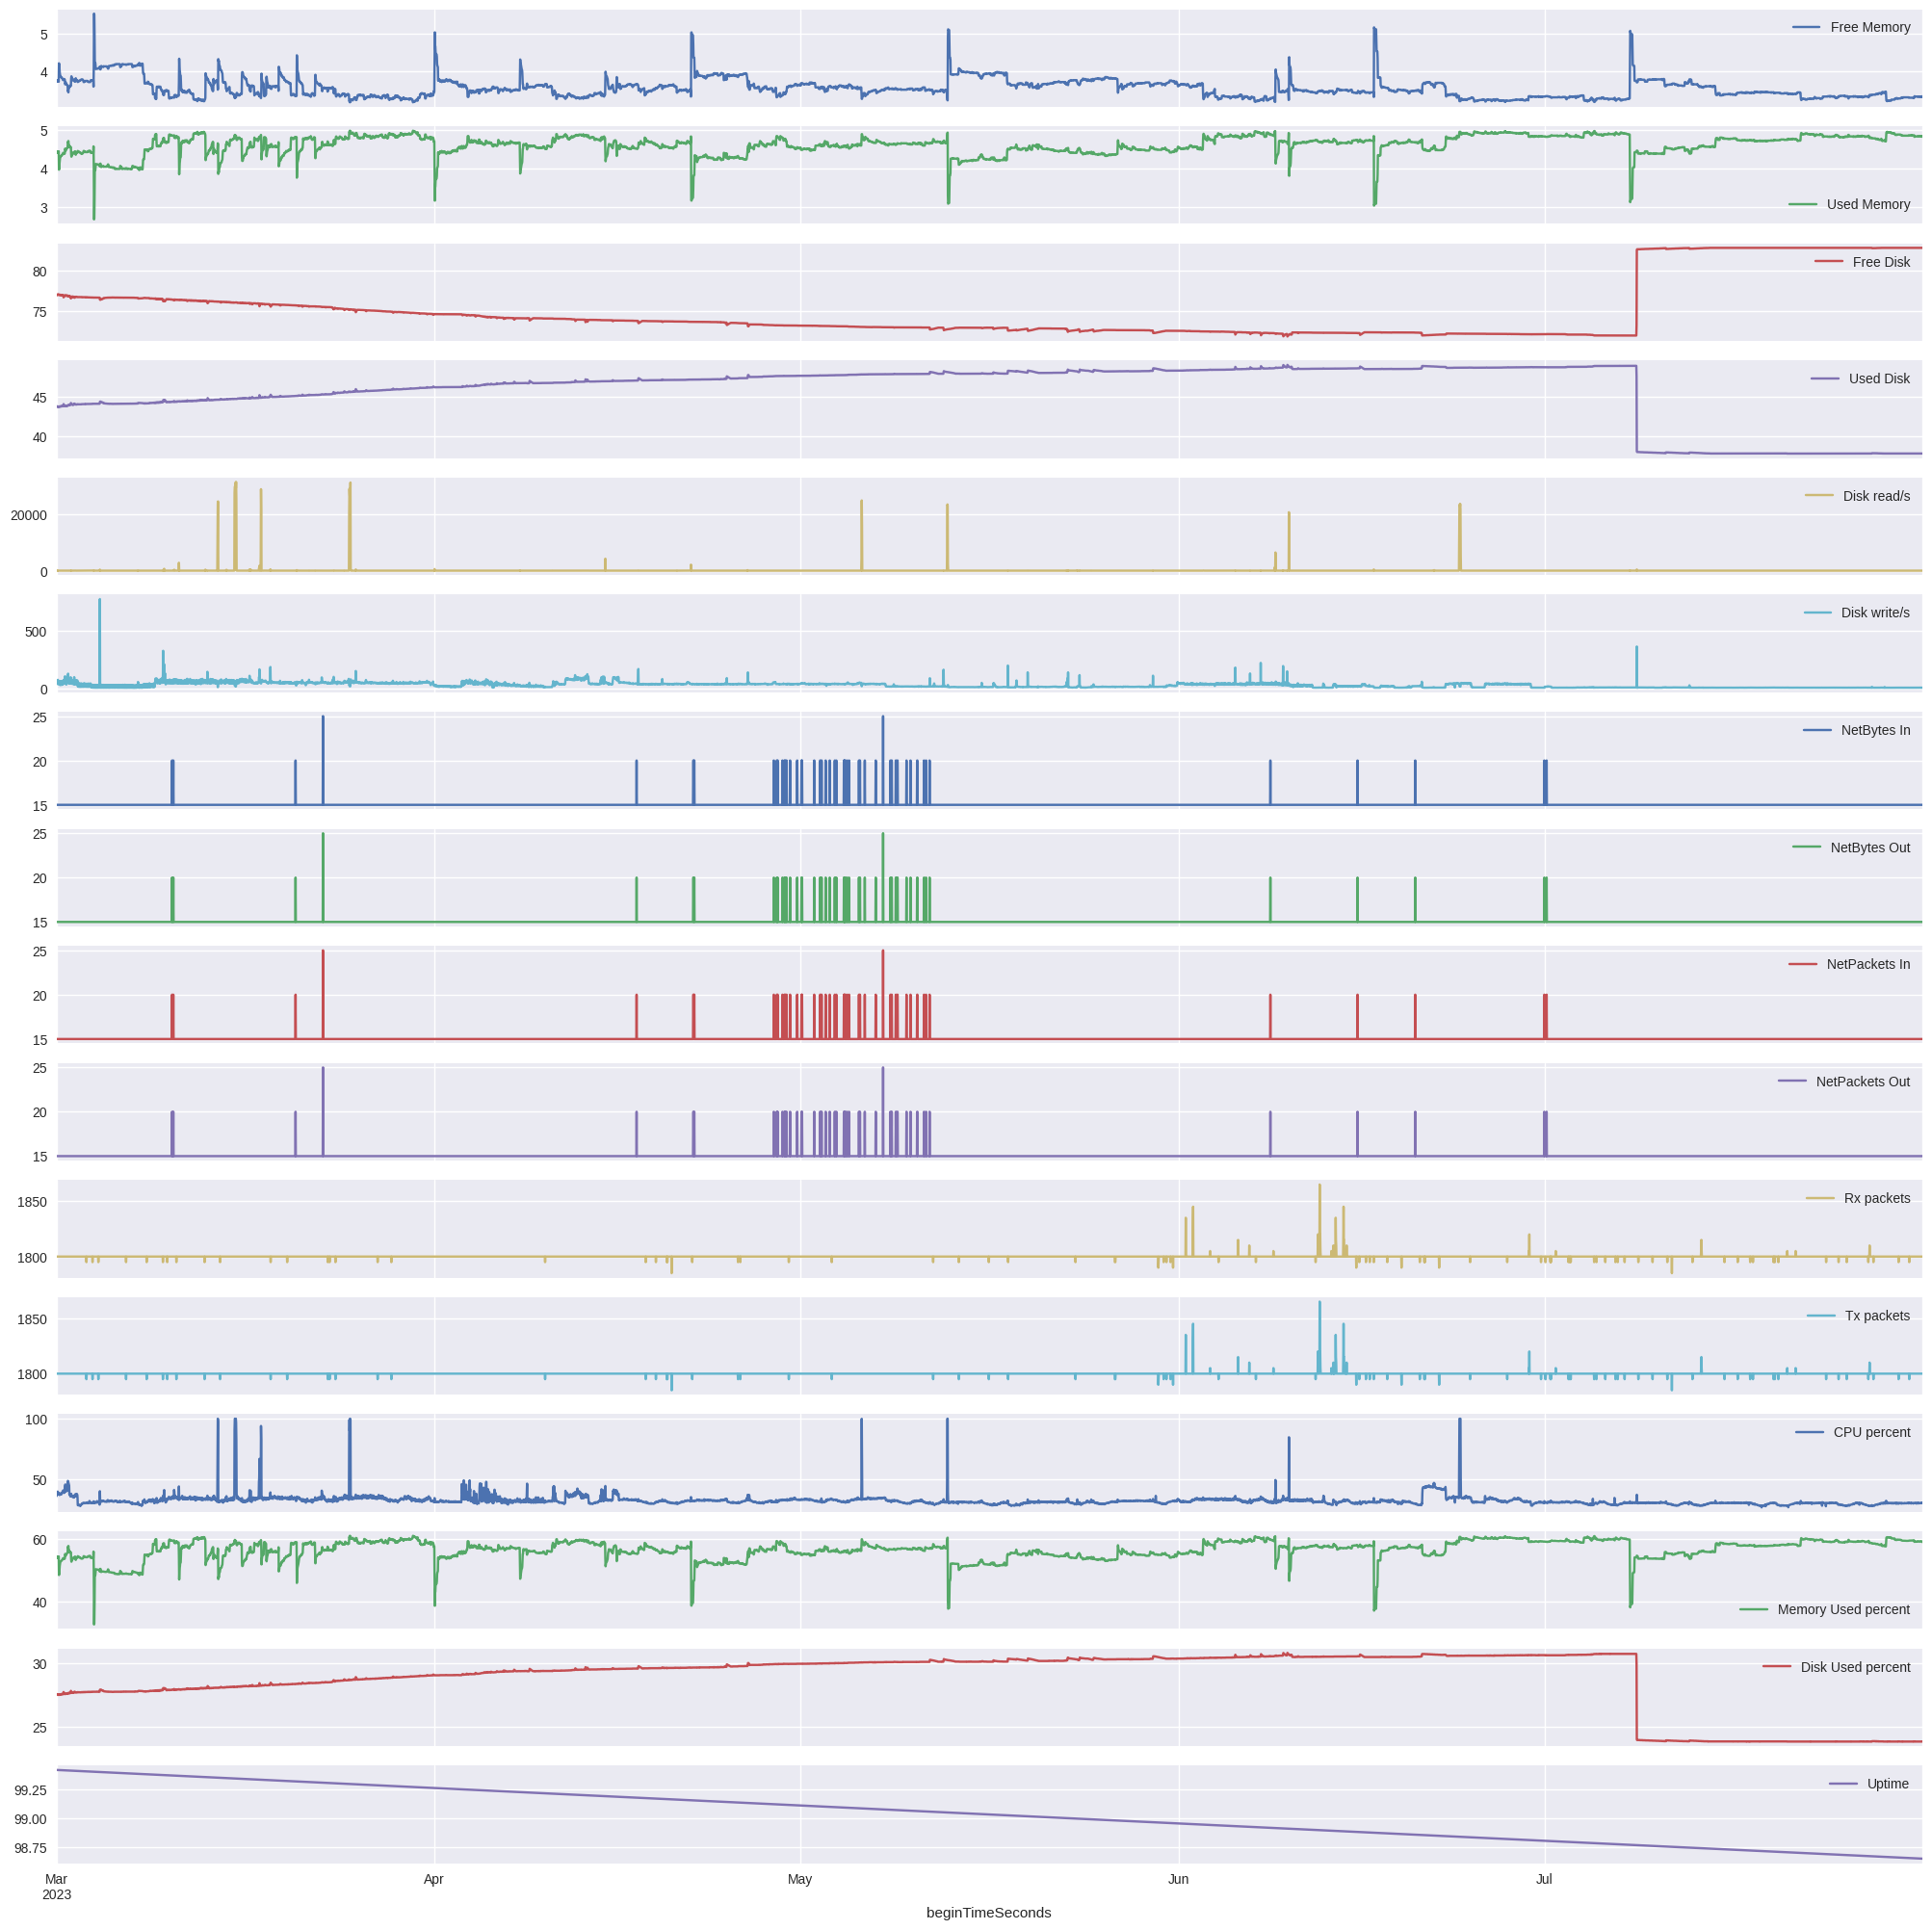

In [ ]:
cols = df.columns

N = df.shape[0]
plots = df[cols][:N]
# plots.index = df['beginTimeSeconds'][0:N]
plots.index = df.index[:N]
_ = plots.plot(subplots=True, figsize=(25,25))

## 3. Feature management



It is necessary to eliminate a certain segment of the information due to its lack of temporality, since it would generate errors during training.
The information to be predicted corresponds to data collected after July 5, 2023.

In [ ]:
df = df[(df.index <= '2023-07-05 00:00:00')]

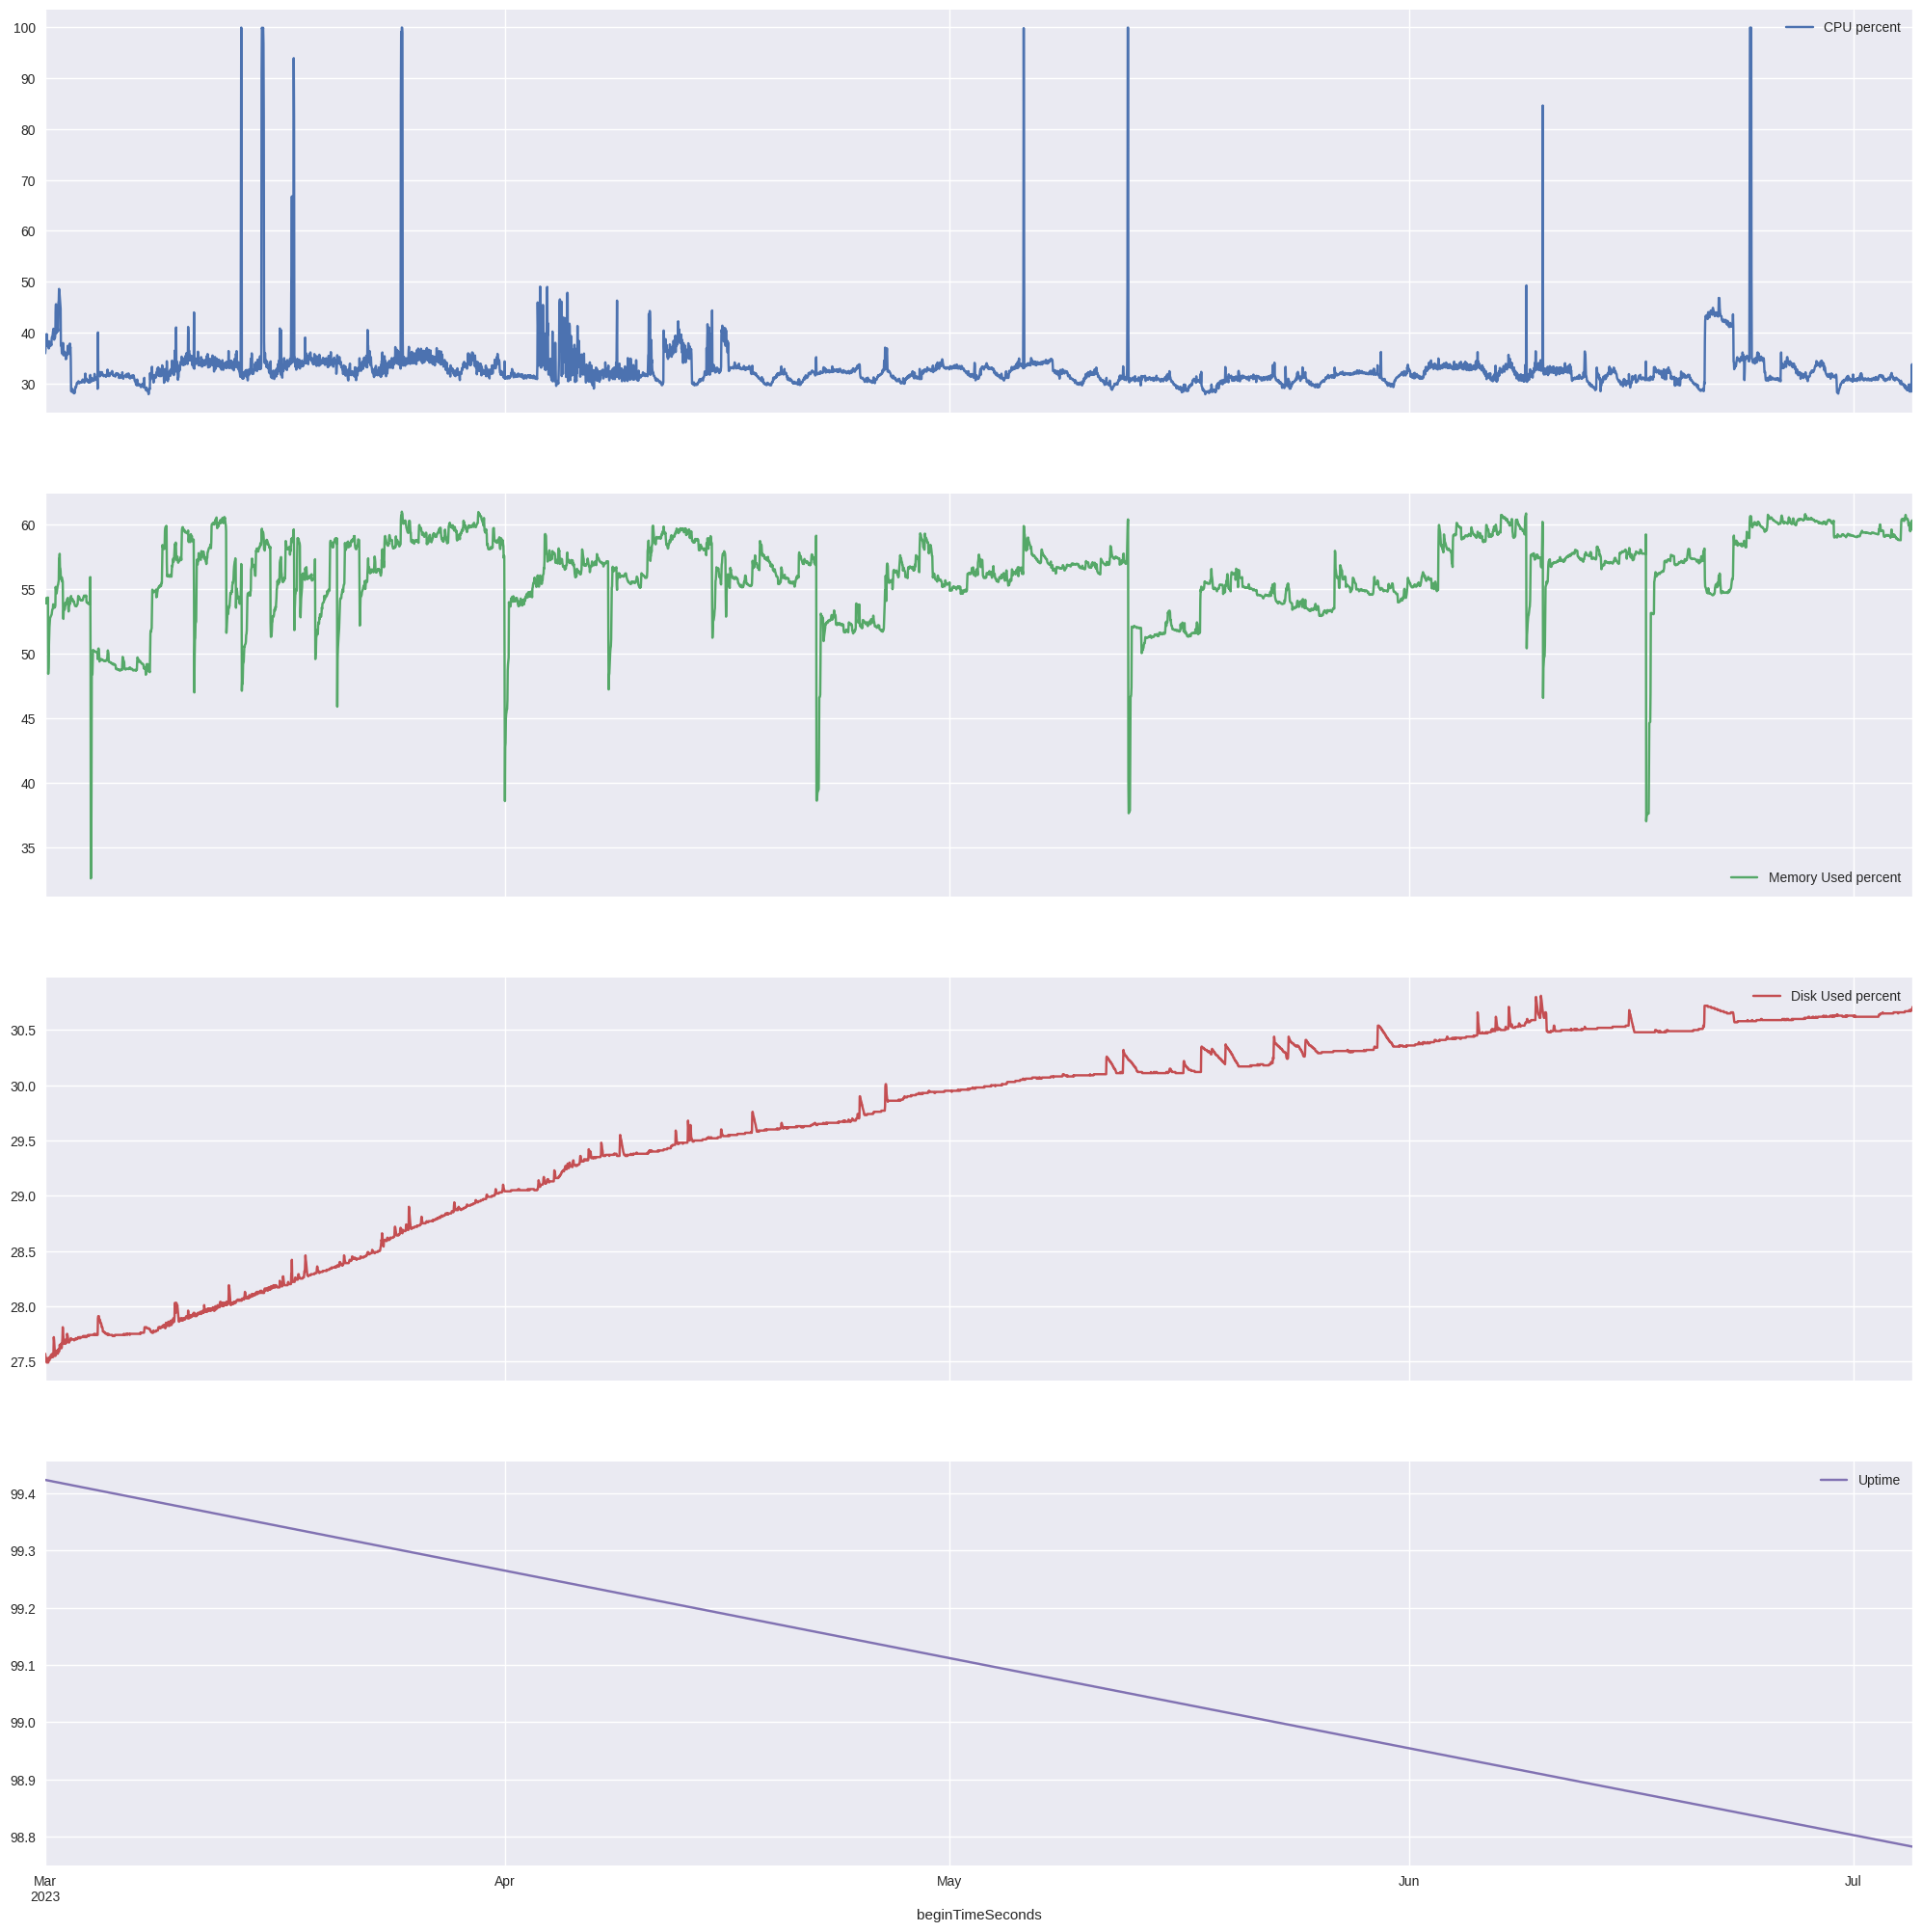

In [ ]:
cols = df.columns

N = df.shape[0]
plots = df[cols[-4:]][:N]
# plots.index = df['beginTimeSeconds'][0:N]
plots.index = df.index[0:N] # Time Variable
_ = plots.plot(subplots=True, figsize=(25,25))

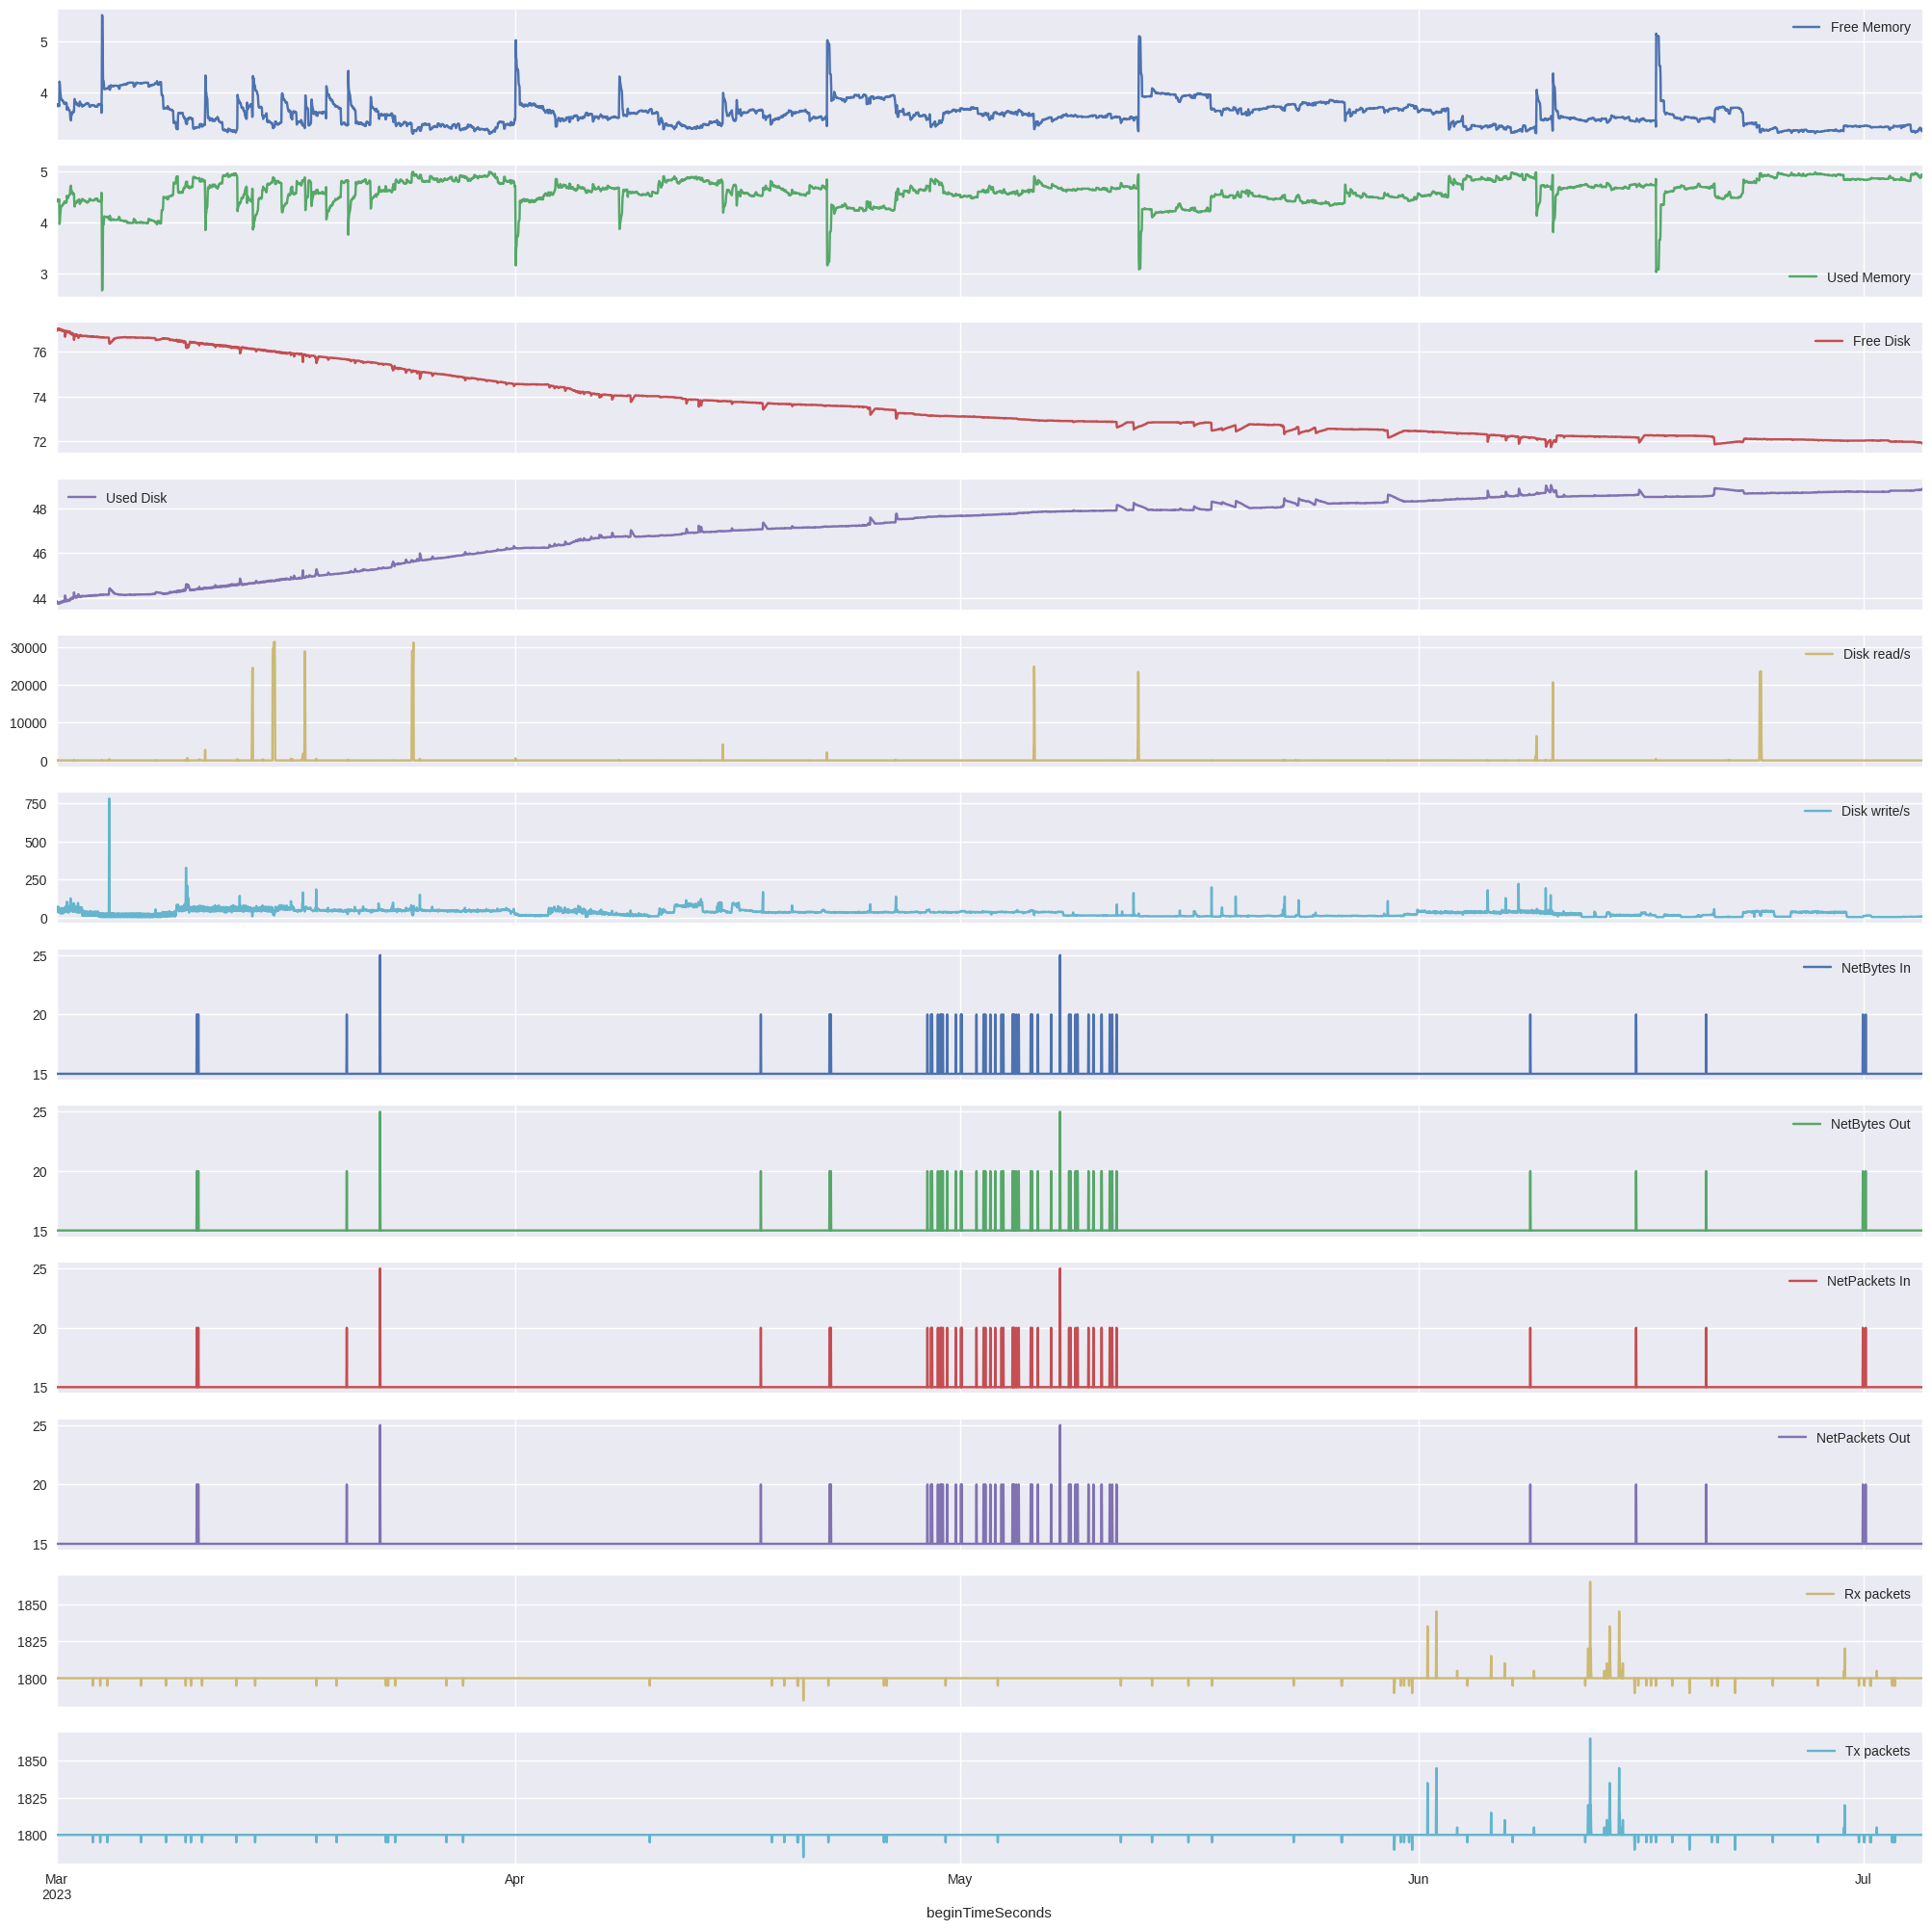

In [ ]:
cols = df.columns

N = df.shape[0]
plots = df[cols[:-4]][:N] # Series
# plots.index = df['beginTimeSeconds'][0:N]
plots.index = df.index[0:N]
_ = plots.plot(subplots=True, figsize=(25,25))

In [ ]:
df.shape

(6049, 16)

##3.1 Description

In [ ]:
for column in df.columns:
  print(f'\nVariable [{column}]\n', df[column].describe())


Variable [Free Memory]
 count    6049.000000
mean        3.586995
std         0.250336
min         3.200000
25%         3.400000
50%         3.550000
75%         3.700000
max         5.520000
Name: Free Memory, dtype: float64

Variable [Used Memory]
 count    6049.000000
mean        4.602232
std         0.250353
min         2.670000
25%         4.490000
50%         4.640000
75%         4.790000
max         4.990000
Name: Used Memory, dtype: float64

Variable [Free Disk]
 count    6049.000000
mean       73.601152
std         1.477678
min        71.740000
25%        72.350000
50%        73.060000
75%        74.550000
max        77.050000
Name: Free Disk, dtype: float64

Variable [Used Disk]
 count    6049.000000
mean       47.183316
std         1.477693
min        43.730000
25%        46.230000
50%        47.720000
75%        48.430000
max        49.050000
Name: Used Disk, dtype: float64

Variable [Disk read/s]
 count     6049.000000
mean       132.422352
std       1772.217510
min      

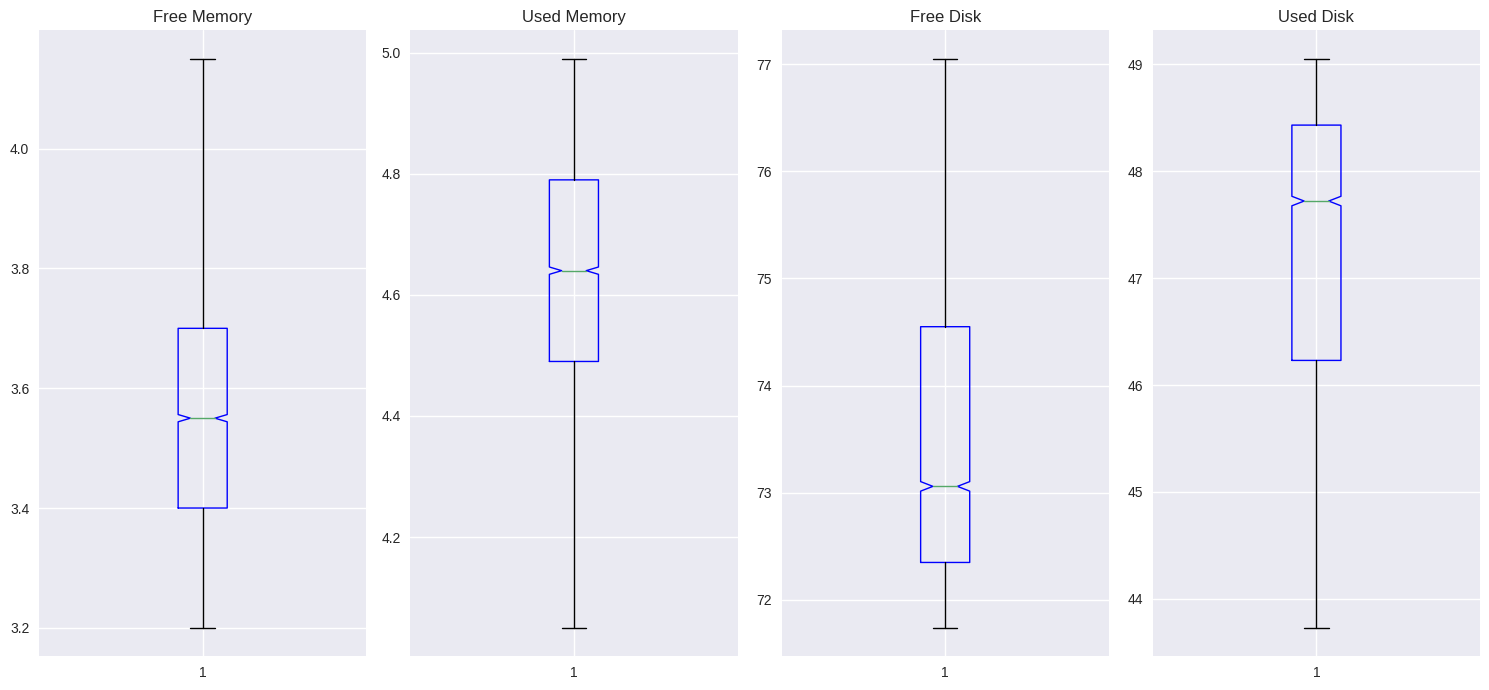

In [ ]:
draw_columns = df.columns
fig, axes = plt.subplots(1, len(draw_columns[:4]),figsize =(15, 7))

for draw_column, axe in zip(draw_columns[:4], axes):
  box = axe.boxplot(df[draw_column], notch=True, vert=True, autorange=True, sym="")
  for box in box['boxes']:
    box.set_color('b')
    axe.set_title(draw_column)
plt.tight_layout()
plt.show()

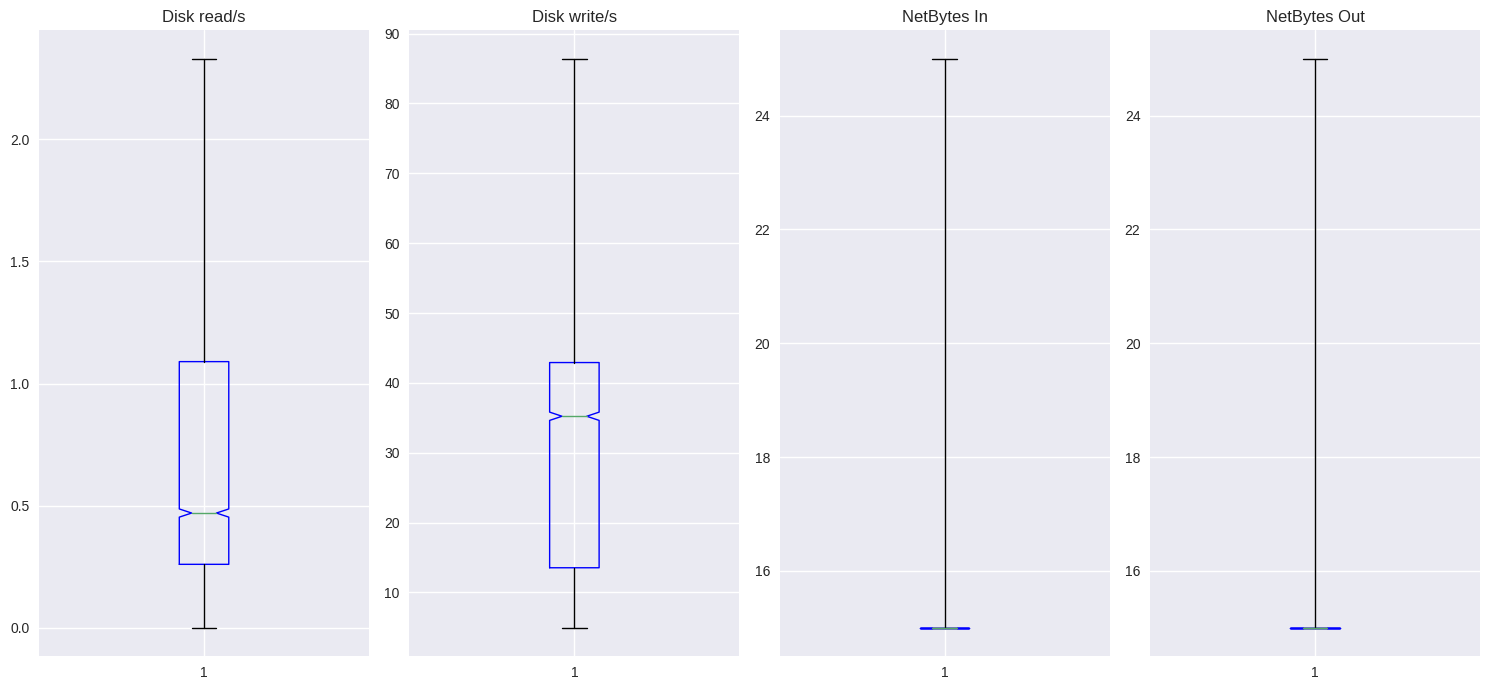

In [ ]:
fig, axes = plt.subplots(1, len(draw_columns[4:8]),figsize =(15, 7))

for draw_column, axe in zip(draw_columns[4:8], axes):
  box = axe.boxplot(df[draw_column], notch=True, vert=True, autorange=True, sym="")
  for box in box['boxes']:
    box.set_color('b')
    axe.set_title(draw_column)
plt.tight_layout()
plt.show()

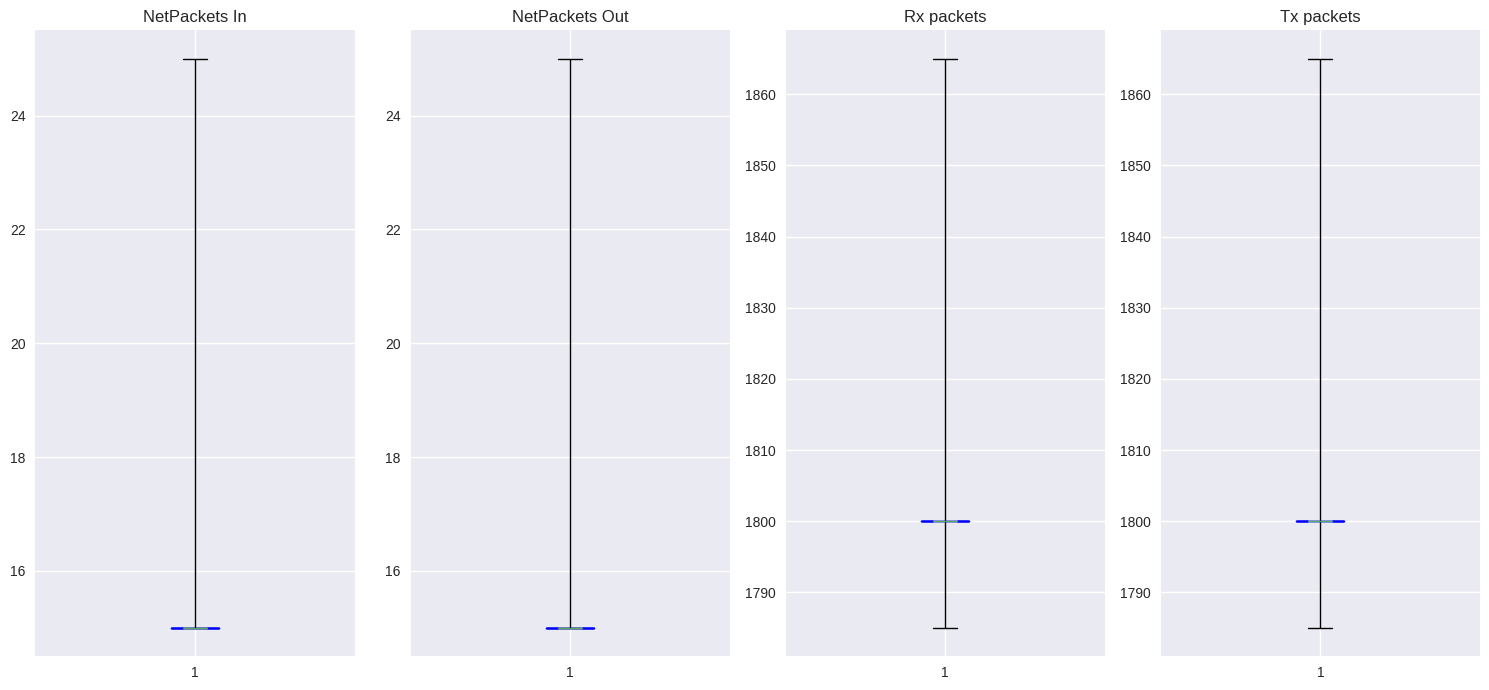

In [ ]:
fig, axes = plt.subplots(1, len(draw_columns[8:12]),figsize =(15, 7))

for draw_column, axe in zip(draw_columns[8:12], axes):
  box = axe.boxplot(df[draw_column], notch=True, vert=True, autorange=True, sym="")
  for box in box['boxes']:
    box.set_color('b')
    axe.set_title(draw_column)
plt.tight_layout()
plt.show()

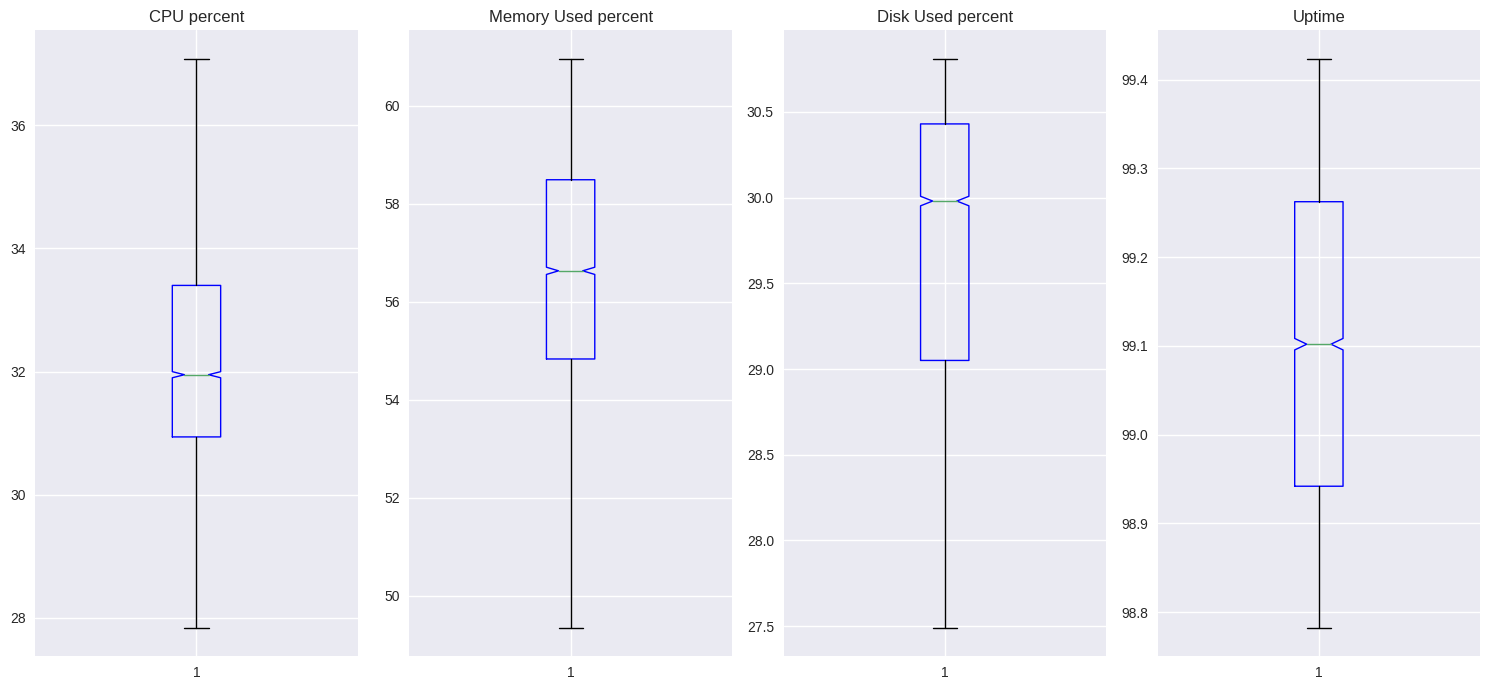

In [ ]:
fig, axes = plt.subplots(1, len(draw_columns[12:]),figsize =(15, 7))

for draw_column, axe in zip(draw_columns[12:], axes):
  box = axe.boxplot(df[draw_column], notch=True, vert=True, autorange=True, sym="")
  for box in box['boxes']:
    box.set_color('b')
    axe.set_title(draw_column)
plt.tight_layout()
plt.show()

## 3.2 Variability determination


In [ ]:
print(len(df.columns))
for column in df.columns:
  arr = df[column].unique()
  print(f'Column: [{column}] :: Unique data [{arr}], Total Unique Data [{len(arr)}]')

In [ ]:
# df['CPU percent'] = df['CPU percent'].round(2)
# df['Uptime'] = df['Uptime'].round(2)
# df['Disk read/s'] = df['Disk read/s'].apply(lambda x: round(float(x), 4))
# df['Disk write/s'] = df['Disk write/s'].apply(lambda x: round(float(x), 2))
# df['Disk Used percent'] = df['Disk Used percent'].round(2)
# df['Memory Used percent'] = df['Memory Used percent'].round(2)
# df['Free Memory'] = df['Free Memory'].apply(lambda x: round(float(x) / 1e9, 2))
# df['Free Disk'] = df['Free Disk'].apply(lambda x: round(float(x) / 1e9, 2))
# df['Used Disk'] = df['Used Disk'].apply(lambda x: round(float(x) / 1e9, 2))
# df['Used Memory'] = df['Used Memory'].apply(lambda x: round(float(x) / 1e9, 2))

In [ ]:
df.head()

,Free Memory,Used Memory,Free Disk,Used Disk,Disk read/s,Disk write/s,NetBytes In,NetBytes Out,NetPackets In,NetPackets Out,Rx packets,Tx packets,CPU percent,Memory Used percent,Disk Used percent,Uptime
beginTimeSeconds,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,3.75,4.44,76.93,43.86,14.12,44.97,15,15,15,15,1800,1800,35.89,54.23,27.57,99.4234
2023-03-01 00:30:00,3.76,4.43,76.94,43.84,5.19,41.19,15,15,15,15,1800,1800,36.57,54.14,27.55,99.4233
2023-03-01 01:00:00,3.77,4.41,77.00,43.78,23.64,70.99,15,15,15,15,1800,1800,37.94,53.91,27.52,99.4232
2023-03-01 01:30:00,3.78,4.41,77.00,43.79,5.25,38.45,15,15,15,15,1800,1800,37.40,53.86,27.52,99.4231
2023-03-01 02:00:00,3.76,4.43,77.01,43.77,9.42,43.94,15,15,15,15,1800,1800,38.08,54.11,27.51,99.4230


### 3.3 Correlation matrix

The correlation of variables is identified.
A higher correlation when the values are closer to -1 and 1.
It indicates if the variables have an impact on each other.

In [ ]:
correlation_matrix = df.corr()

print(correlation_matrix)

Matriz de correlación:
                     Free Memory  Used Memory  Free Disk  Used Disk  \
Free Memory             1.000000    -0.999943   0.213579  -0.213530   
Used Memory            -0.999943     1.000000  -0.213727   0.213678   
Free Disk               0.213579    -0.213727   1.000000  -0.999994   
Used Disk              -0.213530     0.213678  -0.999994   1.000000   
Disk read/s            -0.077635     0.077848   0.050975  -0.050963   
Disk write/s           -0.233031     0.233043   0.362643  -0.362723   
NetBytes In            -0.003741     0.003696  -0.023508   0.023575   
NetBytes Out           -0.003741     0.003696  -0.023508   0.023575   
NetPackets In          -0.003741     0.003696  -0.023508   0.023575   
NetPackets Out         -0.003741     0.003696  -0.023508   0.023575   
Rx packets             -0.018790     0.018873  -0.040164   0.040189   
Tx packets             -0.018790     0.018873  -0.040164   0.040189   
CPU percent            -0.146697     0.146768   0.1400

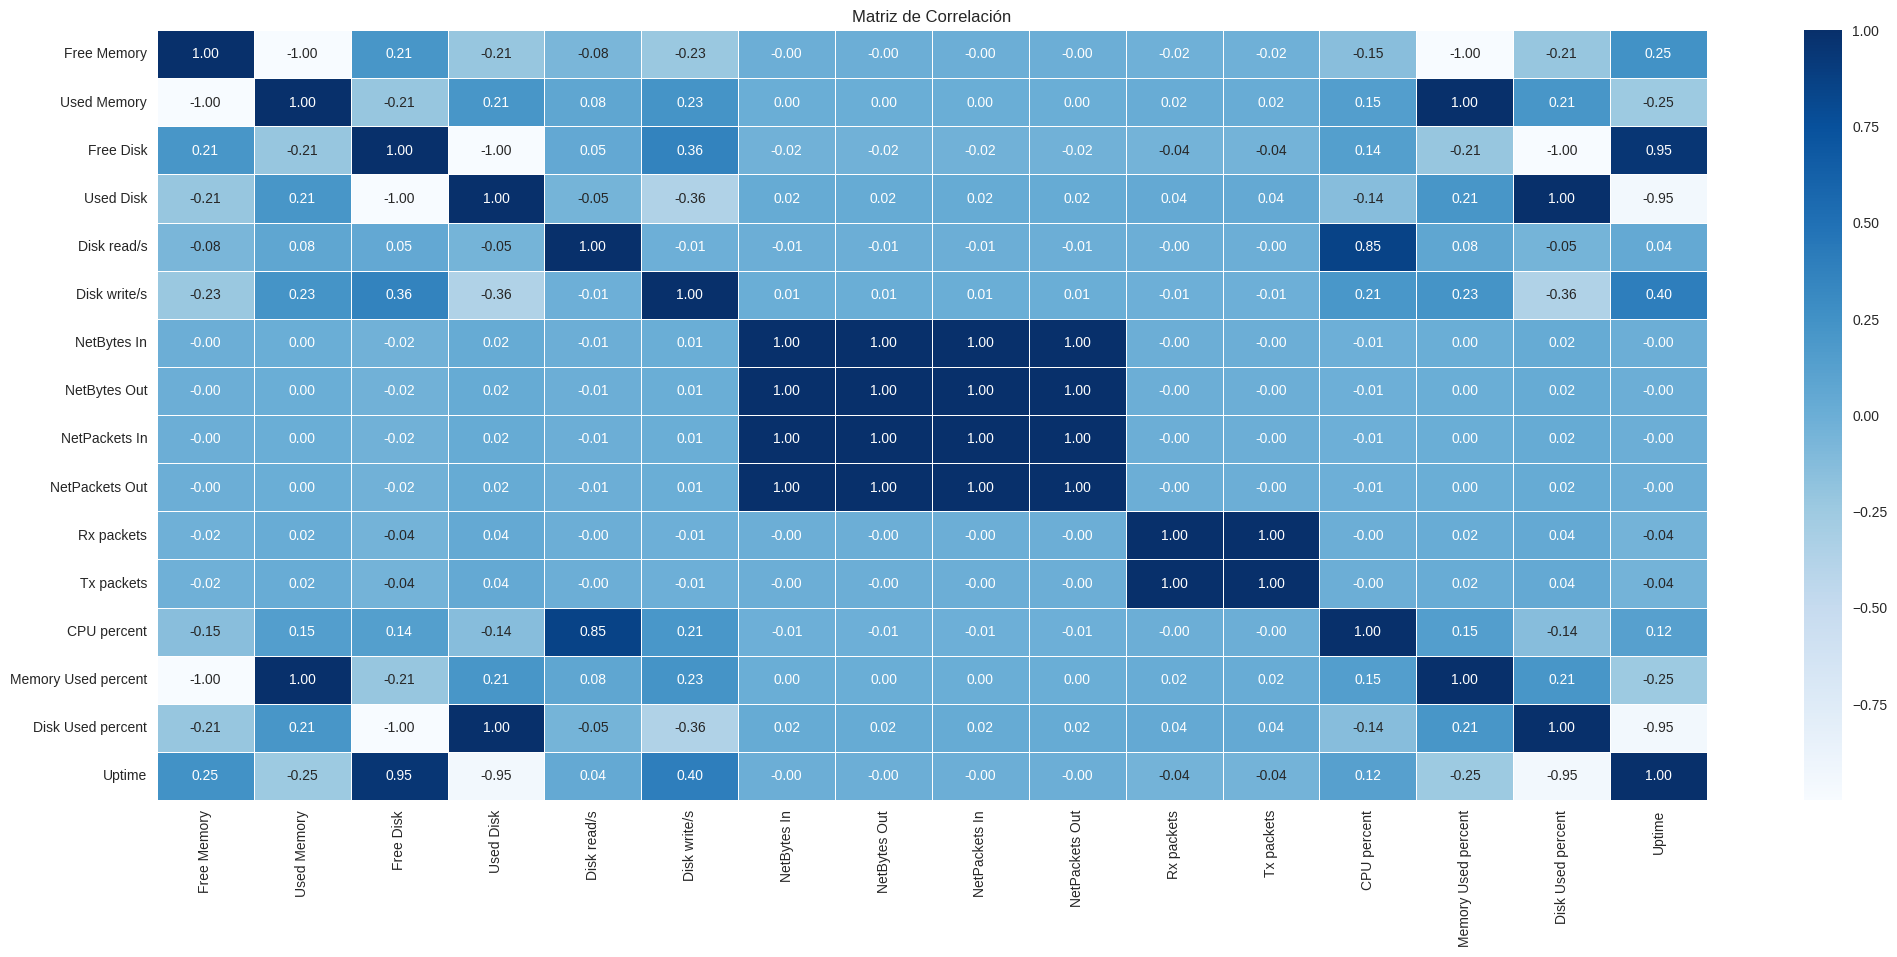

In [ ]:
import seaborn as sns

plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

##4. Pre-processing

It involves:

1. train/val/test partition (70%, 15%, 15%).
2. Generation of supervised dataset: model input and output.
3. Scaling (Normalize)

In each of these phases the same code used in the univariate models is applied but with some slight modifications.

### 4.1. Set Partitioning in Training, Validation and Testing

Unlike other Deep Learning models, in the case of time series **it must be guaranteed that the partitions are generated without randomly mixing the data**.

Note:
- The training set (*train*) will be used to find the model parameters.
- The validation set (*val*) to verify that there is no *under/over-fitting* of the model and to adjust its hyperparameters.
- The test set (*test*) to test the best model found during training/validation.

In this case we will use the same function implemented for the univariate models with the difference that instead of entering a *series* of Pandas, we will enter the complete *DataFrame*.

Therefore, the function will return three *dataframes* (train, val and test):

In [ ]:
data_length = df.shape[0]

train_percentage = 0.7
validation_percentage = 0.15
test_percentage = 0.15

train_length, validation_length, test_length = data_length *train_percentage, data_length * validation_percentage, data_length * test_percentage
train_length, validation_length, test_length

(4234.3, 907.35, 907.35)

In [ ]:
df.shape

(6049, 16)

In [ ]:
4235 + 907 + 907

6049

In [ ]:
dfr = df.reset_index()

In [ ]:
new_order_columns = [
    'Free Memory',
    'Used Memory',
    'Free Disk',
    'Used Disk',
    'Disk read/s',
    'Disk write/s',
    'NetBytes In',
    'NetBytes Out',
    'NetPackets In',
    'NetPackets Out',
    'Rx packets',
    'Tx packets',
    'CPU percent',
    'Memory Used percent',
    'Disk Used percent',
    'Uptime',
]

In [ ]:
col = 'NetPackets Out'

In [ ]:
dfr.loc[0:train_length, [col]]

,NetPackets Out
0,15
1,15
2,15
3,15
4,15
...,...
4231,15
4232,15
4233,15
4234,15


In [ ]:
# scaler = MinMaxScaler(feature_range=(-1,1))
# dfr = scaler.fit_transform(dfr[[col]])
# dfr

In [ ]:
train_length = 4235
validation_length = train_length + 907
test_length = train_length + validation_length + 907

tr_ds = df[0:train_length][[col]]
val_ds = df[train_length:validation_length][[col]]
ts_ds = df[validation_length:test_length][[col]]

print(f'Size of training subset: {tr_ds.shape}')
print(f'Size of validation subset: {val_ds.shape}')
print(f'Size of test subset: {ts_ds.shape}')

In [ ]:
pd.DataFrame(tr_ds)

,NetPackets Out
beginTimeSeconds,
2023-03-01 00:00:00,15
2023-03-01 00:30:00,15
2023-03-01 01:00:00,15
2023-03-01 01:30:00,15
2023-03-01 02:00:00,15
...,...
2023-05-28 03:00:00,15
2023-05-28 03:30:00,15
2023-05-28 04:00:00,15


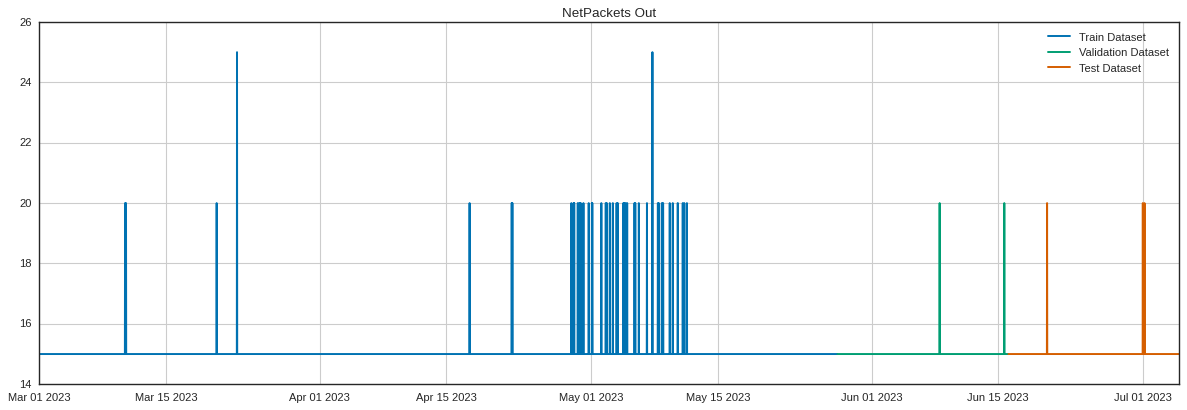

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

plt.plot(tr_ds.index, tr_ds[col], label='Train Dataset')
plt.plot(val_ds.index, val_ds[col], label='Validation Dataset')
plt.plot(ts_ds.index, ts_ds[col], label='Test Dataset')
plt.title(col)
plt.legend()


plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_dataset.png')

plt.tight_layout()
plt.show()

In [ ]:
def create_supervised_dataset(dataset, input_length, output_length):
  X = []
  Y = []
  rows = dataset.shape[0]
  for i in range(rows - input_length - output_length + 1):
    X.append(dataset[i:i + input_length])
    Y.append(dataset[i + input_length:i + input_length + output_length])
  return np.array(X), np.array(Y)

In [ ]:
tr_ds.shape, val_ds.shape, ts_ds.shape

((4235, 1), (907, 1), (907, 1))

In [ ]:
INPUT_LENGTH = 48    # Hyperparameter
OUTPUT_LENGTH = 6

x_tr_ds, y_tr_ds = create_supervised_dataset(tr_ds.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_val_ds, y_val_ds = create_supervised_dataset(val_ds.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts_ds, y_ts_ds = create_supervised_dataset(ts_ds.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
print('Input (BATCHES x INPUT_LENGTH x FEATURES) and output sizes (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Train Set - x_tr: {x_tr_ds.shape}, y_tr: {y_tr_ds.shape}')
print(f'Validation Set - x_vl: {x_val_ds.shape}, y_vl: {y_val_ds.shape}')
print(f'Test Set - x_ts: {x_ts_ds.shape}, y_ts: {y_ts_ds.shape}')

In [ ]:
4182 + 48 + 6

4236

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generate list with "scalers" (1 for each input covariate)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Scaling: the min/max of the training set will be used to scale all the datasets.

    # Scaling Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr_ds[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts_ds[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_val_ds[:,:,i])

    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr_ds[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_val_ds[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts_ds[:,:,0])


    # Create output dictionary
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers

In [ ]:
data_in = {
    'x_tr': x_tr_ds, 'y_tr': y_tr_ds,
    'x_vl': x_val_ds, 'y_vl': y_val_ds,
    'x_ts': x_ts_ds, 'y_ts': y_ts_ds,
}

# Y scalar (specifying the column with the variable to predict)
data_s, scalers = escalar_dataset(data_in,)

# Extract scaled subsets
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [ ]:
x_tr_s.shape, y_tr_s.shape, x_vl_s.shape, y_vl_s.shape, x_ts_s.shape, y_ts_s.shape

((4182, 48, 1),
 (4182, 6, 1),
 (854, 48, 1),
 (854, 6, 1),
 (854, 48, 1),
 (854, 6, 1))

In [ ]:
# And let's generate a violin plot to see the distribution of values in each covariate (input) and in the variable to predict (output).
plt.figure(figsize=(3, 6))

plt.subplot(1, 1, 1)
plt.violinplot(dataset=x_tr_s[:,:,0].flatten(), positions=[0])
plt.violinplot(dataset=x_vl_s[:,:,0].flatten(), positions=[0])
plt.violinplot(dataset=x_ts_s[:,:,0].flatten(), positions=[0])
plt.title(col)

plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_frecuencia.png')
plt.show()

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError

In [ ]:
class MeanAbsoluteScaledError(tf.keras.metrics.Metric):
    def __init__(self, name='mean_absolute_scaled_error', **kwargs):
        super(MeanAbsoluteScaledError, self).__init__(name=name, **kwargs)
        self.mae = MeanAbsoluteError()
        self.mse = RootMeanSquaredError()

        # State variables
        self.total_mae = self.add_weight('total_mae', initializer='zeros')
        self.total_mse = self.add_weight('total_mse', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        mae = self.mae(y_true, y_pred)
        mse = self.mse(y_true, y_pred)

        # Avoid division by zero
        denominator = tf.where(tf.not_equal(mae, 0.0), mae, 1.0)

        # Update state variables
        self.total_mae.assign_add(tf.reduce_sum(mae))
        self.total_mse.assign_add(tf.reduce_sum(mse))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        scaled_error = self.total_mse / self.total_mae
        return scaled_error

    def reset_states(self):
        # Reset state at the end of each epoch or at the start of training
        self.total_mae.assign(0.0)
        self.total_mse.assign(0.0)
        self.count.assign(0.0)

In [ ]:
np.expand_dims(x_tr_ds[:,:,0], -1).shape

(4182, 48, 1)

In [ ]:
64, 64 * 2, 64 * 4, 64 * 6, 64 * 8

(64, 128, 256, 384, 512)

In [ ]:
512 / 16

32.0

In [ ]:
# Model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Flatten, Conv1D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Loss: the RMSE (root mean squared error) will be used for training because it allows to have errors in the same units as each variable.
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

model = Sequential([
    # Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE), ####
    LSTM(128, input_shape=(x_tr_ds.shape[1], 1), return_sequences = True,),
    # Bidirectional(LSTM(128, return_sequences = True,)),
    # LSTM(128, return_sequences = True,),
    Dropout(0.1),
    # Bidirectional(LSTM(128, return_sequences = True)),
    LSTM(128, return_sequences = True),
    # Dropout(0.3),
    # Bidirectional(LSTM(64, return_sequences = False)),
    LSTM(64, return_sequences = False),
    # Dropout(0.3),
    # LSTM(64, return_sequences = False),
    # Dropout(0.2),
    # LSTM(50),
    # Dropout(0.2),
    # Flatten(),

    # Dense(64, activation='sigmoid'),
    # Dropout(0.2),
    Dense(16, activation='relu'),
    # Dropout(0.3),
    # Dense(16, activation='relu'), ####
    # Dropout(0.3),
    # Dense(8, activation='relu'), ####
    # Dropout(0.2),
    Dense(6, activation='linear')])


model.compile(optimizer = RMSprop(5e-5), loss = root_mean_squared_error, metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError(), MeanAbsoluteScaledError()])

# Training (approximately 1 min using GPU)
EPOCHS = 200
BATCH_SIZE = 256

stories = model.fit(
    x = np.expand_dims(x_tr_s[:,:,0], axis=-1),
    y = np.expand_dims(y_tr_s[:,:,0], axis=-1),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (np.expand_dims(x_vl_s[:,:,0], axis=-1), np.expand_dims(y_vl_s[:,:,0], axis=-1)),
    verbose=2,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
  )

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric MeanAbsoluteScaledError implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


17/17 - 5s - loss: 0.9424 - mean_absolute_error: 0.9322 - mean_absolute_percentage_error: 1162213.2500 - mean_absolute_scaled_error: 1.0081 - val_loss: 0.9156 - val_mean_absolute_error: 0.8993 - val_mean_absolute_percentage_error: 414524.0312 - val_mean_absolute_scaled_error: 1.0120 - 5s/epoch - 313ms/step
Epoch 2/200
17/17 - 0s - loss: 0.8915 - mean_absolute_error: 0.8600 - mean_absolute_percentage_error: 2594709.7500 - mean_absolute_scaled_error: 1.0176 - val_loss: 0.8712 - val_mean_absolute_error: 0.8208 - val_mean_absolute_percentage_error: 738345.8750 - val_mean_absolute_scaled_error: 1.0255 - 233ms/epoch - 14ms/step
Epoch 3/200
17/17 - 0s - loss: 0.8548 - mean_absolute_error: 0.7854 - mean_absolute_percentage_error: 4084884.7500 - mean_absolute_scaled_error: 1.0352 - val_loss: 0.8430 - val_mean_absolute_error: 0.7521 - val_mean_absolute_percentage_error: 1005474.9375 - val_mean_absolute_scaled_error: 1.0462 - 223ms/epoch - 13ms/step
Epoch 4/200
17/17 - 0s - loss: 0.8327 - mean_ab

In [ ]:
x_tr_s.shape, y_tr_s.shape, x_vl_s.shape, y_vl_s.shape, x_ts_s.shape, y_ts_s.shape

((4182, 48, 1),
 (4182, 6, 1),
 (854, 48, 1),
 (854, 6, 1),
 (854, 48, 1),
 (854, 6, 1))

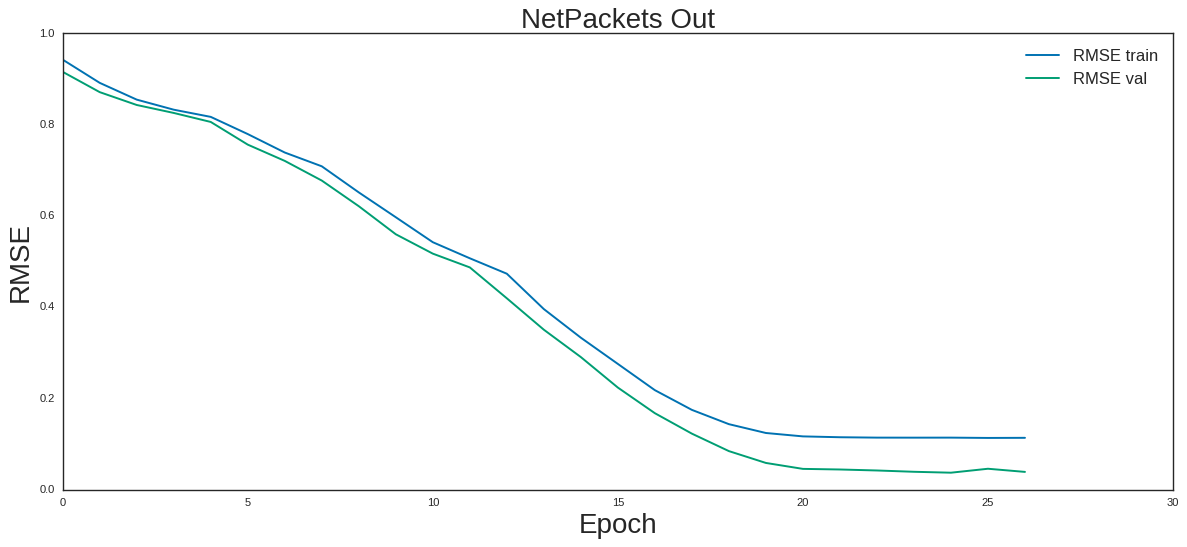

In [ ]:
# Plot training and validation curves to verify that there is no overfitting.
plt.figure(figsize=(15, 7))
plt.subplot(1, 1, 1)
plt.plot(stories.history['loss'], label='RMSE train')
plt.plot(stories.history['val_loss'],label='RMSE val')
plt.title(col, fontsize=25)
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('RMSE', fontsize=25)
plt.legend(fontsize=15);

plt.grid(False)
plt.savefig(f'{col.replace("/", "_")}_mrse.png')
plt.tight_layout()
plt.show()

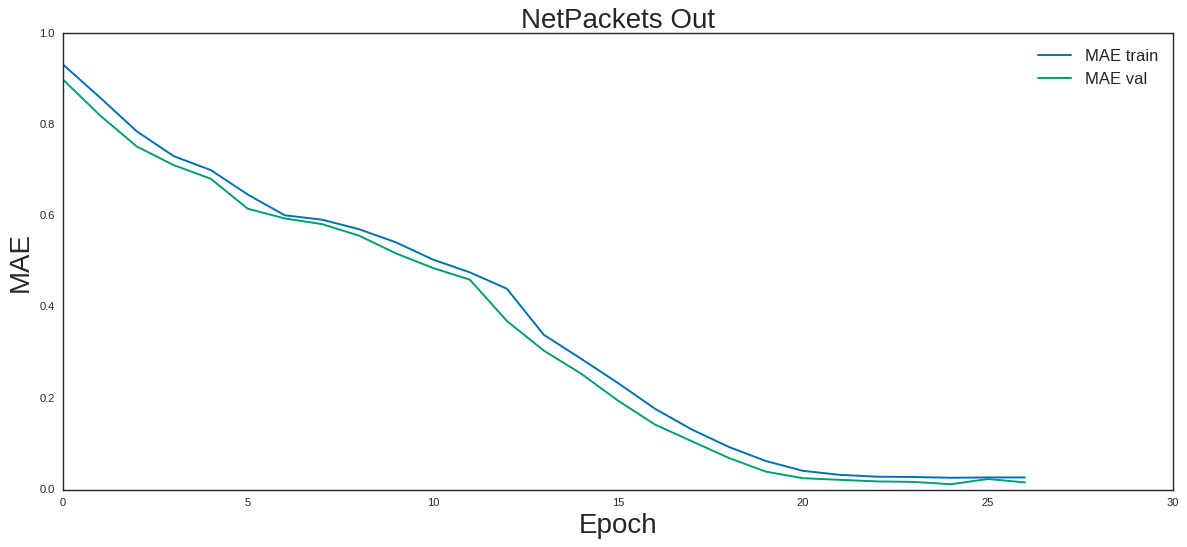

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 1, 1)
plt.plot(stories.history['mean_absolute_error'], label='MAE train')
plt.plot(stories.history['val_mean_absolute_error'],label='MAE val')
plt.title(col,  fontsize=25)
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('MAE', fontsize=25)
plt.legend(fontsize=15);

plt.grid(False)
plt.savefig(f'{col.replace("/", "_")}_mae.png')
plt.tight_layout()
plt.show()

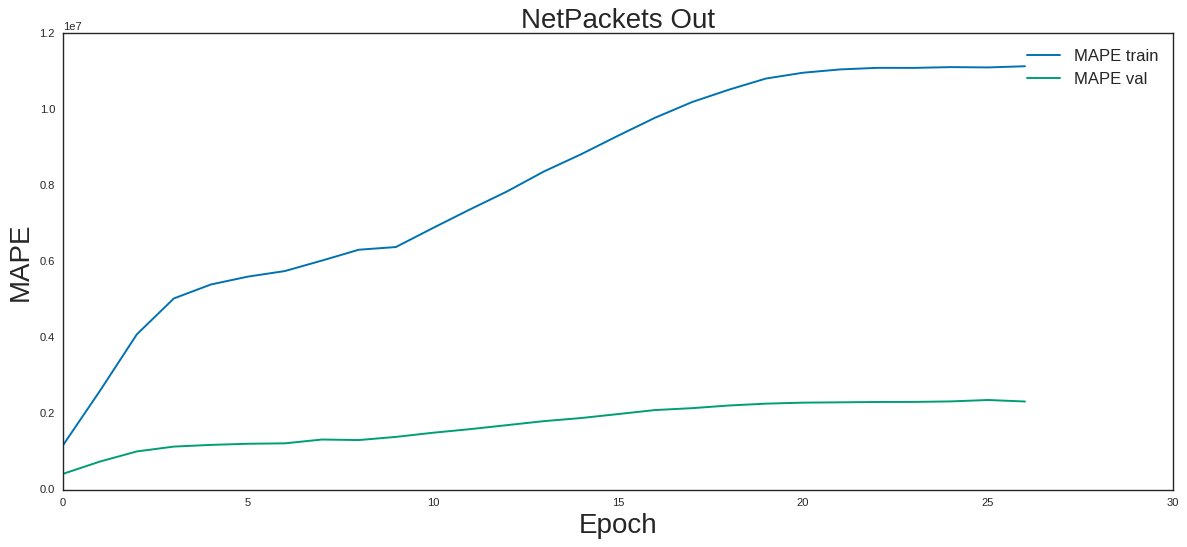

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 1, 1)
plt.plot(stories.history['mean_absolute_percentage_error'], label='MAPE train')
plt.plot(stories.history['val_mean_absolute_percentage_error'],label='MAPE val')
plt.title(col, fontsize=25)
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('MAPE', fontsize=25)
plt.legend(fontsize=15);

plt.grid(False)
plt.savefig(f'{col.replace("/", "_")}_mape.png')
plt.tight_layout()
plt.show()

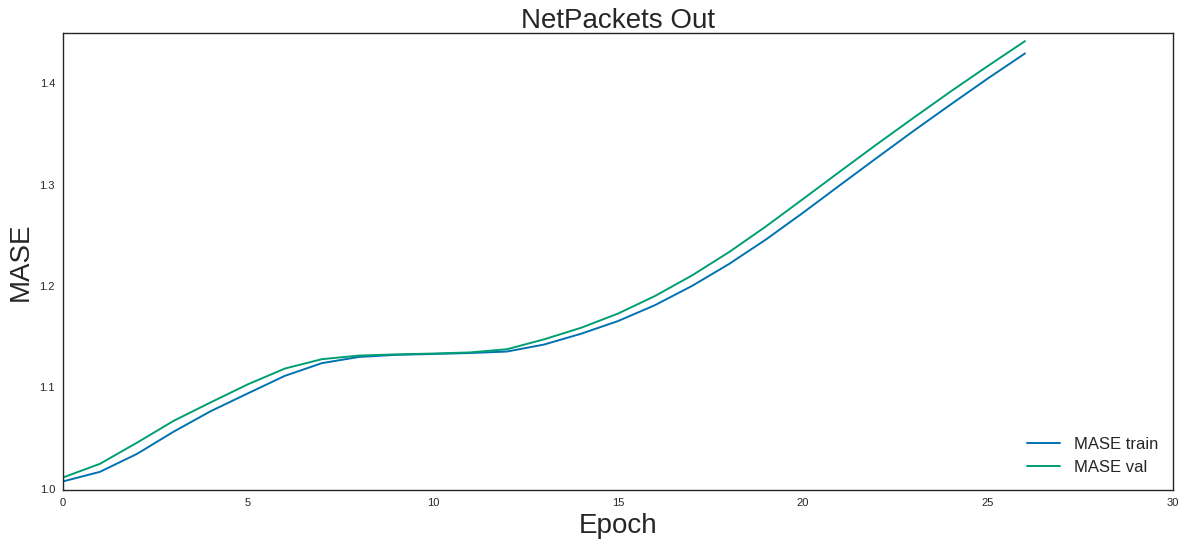

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 1, 1)
plt.plot(stories.history['mean_absolute_scaled_error'], label='MASE train')
plt.plot(stories.history['val_mean_absolute_scaled_error'], label='MASE val')
plt.title(col, fontsize=25)
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('MASE', fontsize=25)
plt.legend(fontsize=15, loc='lower right');

plt.grid(False)
plt.savefig(f'{col.replace("/", "_")}_mase.png')
plt.tight_layout()
plt.show()

In [ ]:
model.save(f'{col.replace("/", "_")}_univ_multistep.keras')

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 48, 128)           66560     
                                                                 
 dropout_22 (Dropout)        (None, 48, 128)           0         
                                                                 
 lstm_67 (LSTM)              (None, 48, 128)           131584    
                                                                 
 lstm_68 (LSTM)              (None, 64)                49408     
                                                                 
 dense_44 (Dense)            (None, 16)                1040      
                                                                 
 dense_45 (Dense)            (None, 6)                 102       
                                                                 
Total params: 248694 (971.46 KB)
Trainable params: 24

In [ ]:
# y_pred_ts = np.array([model.predict(np.expand_dims(x_ts_ds[:,:,index], -1), verbose=0) for index in range(1)])

In [ ]:
y_pred_ts = np.array([model.predict(np.expand_dims(x_ts_s[:,:,index], -1), verbose=0) for index in range(1)])

In [ ]:
y_pred_ts.shape, y_ts_ds.shape

((1, 854, 6), (854, 6, 1))

In [ ]:
np.array([[1],[2]]).shape

(2, 1)

In [ ]:
# scalers[0].inverse_transform([[1],[2]])

In [ ]:
y_pred_ts = np.transpose(y_pred_ts, (1,2,0))

In [ ]:
y_pred_ts.shape

(854, 6, 1)

In [ ]:
y_ts_ds.shape

(854, 6, 1)

In [ ]:
# scalers[0].inverse_transform(y_pred_ts[:, :, 0])[-1, :], y_ts[-1, :, 0]

In [ ]:
def forecast(x_ds, model, scalers):
    return np.expand_dims(scalers[0].inverse_transform(model.predict(np.expand_dims(x_ds[:,:,0], -1), verbose=0)), -1)

In [ ]:
# Calcular predicciones sobre el set de prueba
y_tr_predict = forecast(x_tr_s, model, scalers)
y_vl_predict = forecast(x_vl_s, model, scalers)
y_ts_predict = forecast(x_ts_s, model, scalers)

In [ ]:
y_ts_predict.shape, y_vl_predict.shape, y_tr_predict.shape, y_tr_ds.shape

((854, 6, 1), (854, 6, 1), (4182, 6, 1), (4182, 6, 1))

In [ ]:
y_tr_ds.shape

(4182, 6, 1)

In [ ]:
for index, column in enumerate(tr_ds.columns):
  mae = MeanAbsoluteError()
  mape = MeanAbsolutePercentageError()
  mase = MeanAbsoluteScaledError()
  mae.update_state(y_tr_ds[:, :, index], y_tr_predict[:, :, index])
  mape.update_state(y_tr_ds[:, :, index], y_tr_predict[:, :, index])
  mase.update_state(y_tr_ds[:, :, index], y_tr_predict[:, :, index])

  with open('results_tr.txt', 'a') as file:
    file.write(f'VARIABLE ==> [{column}]\n')
    file.write(f'RMSE -> {round(root_mean_squared_error(y_tr_ds[:, :, index], y_tr_predict[:, :, index]).numpy(), 3)} \n')
    file.write(f'MAE ->  {round(mae.result().numpy(), 3)} \n')
    file.write(f'MAPE -> { round(mape.result().numpy(), 3)} \n')
    file.write(f'MASE -> { round(mase.result().numpy(), 3)} \n')

In [ ]:
for index, column in enumerate(tr_ds.columns):
  mae = MeanAbsoluteError()
  mape = MeanAbsolutePercentageError()
  mase = MeanAbsoluteScaledError()
  mae.update_state(y_val_ds[:, :, index], y_vl_predict[:, :, index])
  mape.update_state(y_val_ds[:, :, index], y_vl_predict[:, :, index])
  mase.update_state(y_val_ds[:, :, index], y_vl_predict[:, :, index])

  with open('results_val.txt', 'a') as file:
    file.write(f'VARIABLE ==> [{column}]\n')
    file.write(f'RMSE -> {round(root_mean_squared_error(y_val_ds[:, :, index], y_vl_predict[:, :, index]).numpy(), 3)}\n')
    file.write(f'MAE -> {round(mae.result().numpy(), 3)}\n')
    file.write(f'MAPE -> {round(mape.result().numpy(), 3)}\n')
    file.write(f'MASE -> {round(mase.result().numpy(), 3)}\n')

In [ ]:
for index, column in enumerate(tr_ds.columns):
  mae = MeanAbsoluteError()
  mape = MeanAbsolutePercentageError()
  mase = MeanAbsoluteScaledError()
  mae.update_state(y_ts_ds[:, :, index], y_ts_predict[:, :, index])
  mape.update_state(y_ts_ds[:, :, index], y_ts_predict[:, :, index])
  mase.update_state(y_ts_ds[:, :, index], y_ts_predict[:, :, index])

  with open('results_ts.txt', 'a') as file:
    file.write(f'VARIABLE ==> [{column}]\n')
    file.write(f'RMSE -> {round(root_mean_squared_error(y_ts_ds[:, :, index], y_ts_predict[:, :, index]).numpy(), 3)}\n')
    file.write(f'MAE -> {round(mae.result().numpy(), 3)}\n')
    file.write(f'MAPE -> {round(mape.result().numpy(), 3)}\n')
    file.write(f'MASE -> {round(mase.result().numpy(), 3)}\n')

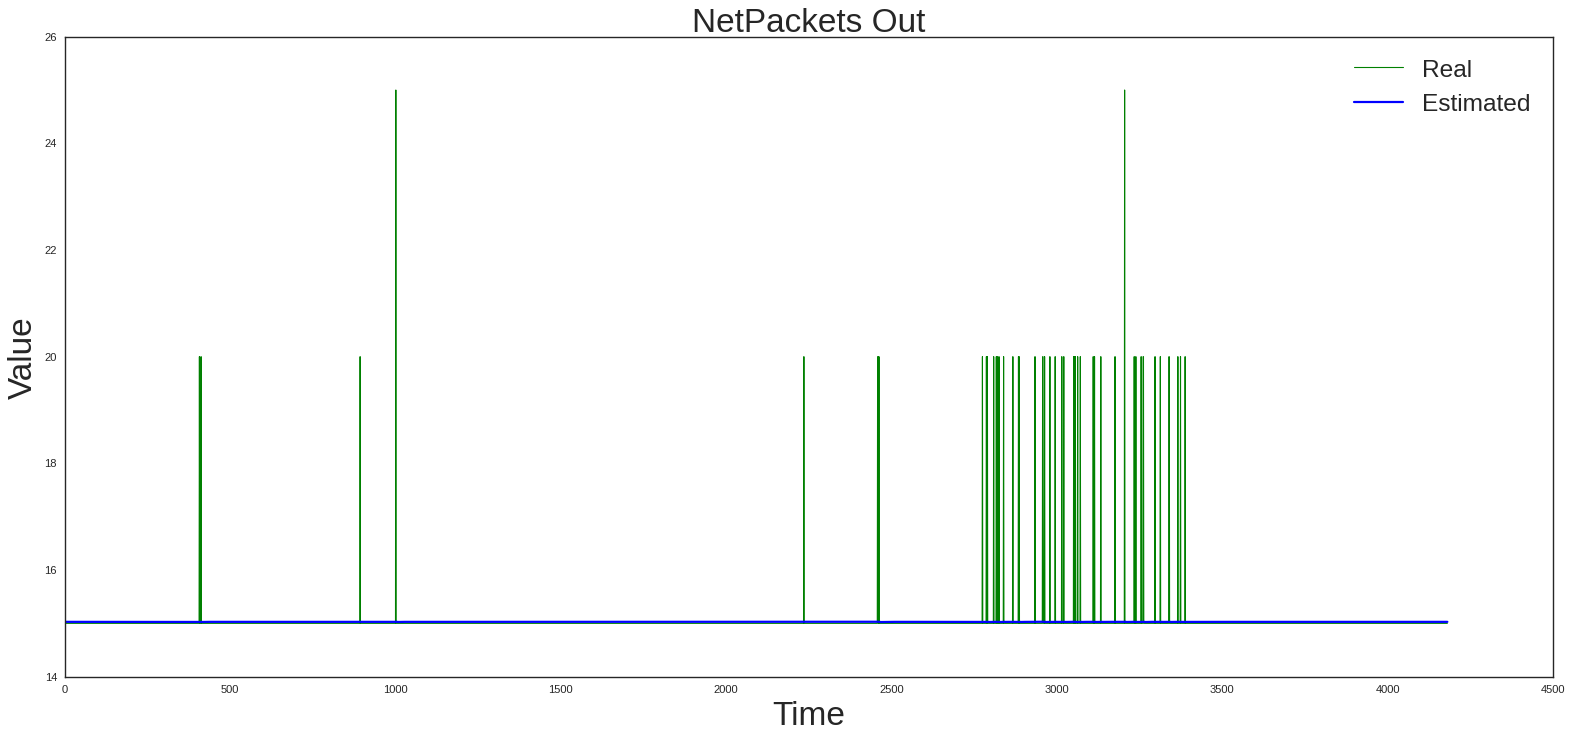

In [ ]:
plt.figure(figsize=(24, 10))
plt.subplot(1, 1, 1)
plt.plot(y_tr_ds[:, 0, index], color = 'green', linewidth=1.0, label='Real', )
plt.plot(y_tr_predict[:, 0, index], color = 'blue', linewidth=2.0, label='Estimated')
plt.title(col, fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Value', fontsize=30)
plt.grid(False)
plt.legend(fontsize=22)
plt.savefig(f'{col.replace("/", "_")}_train_result.png')
plt.show()

# Prediction with test sets

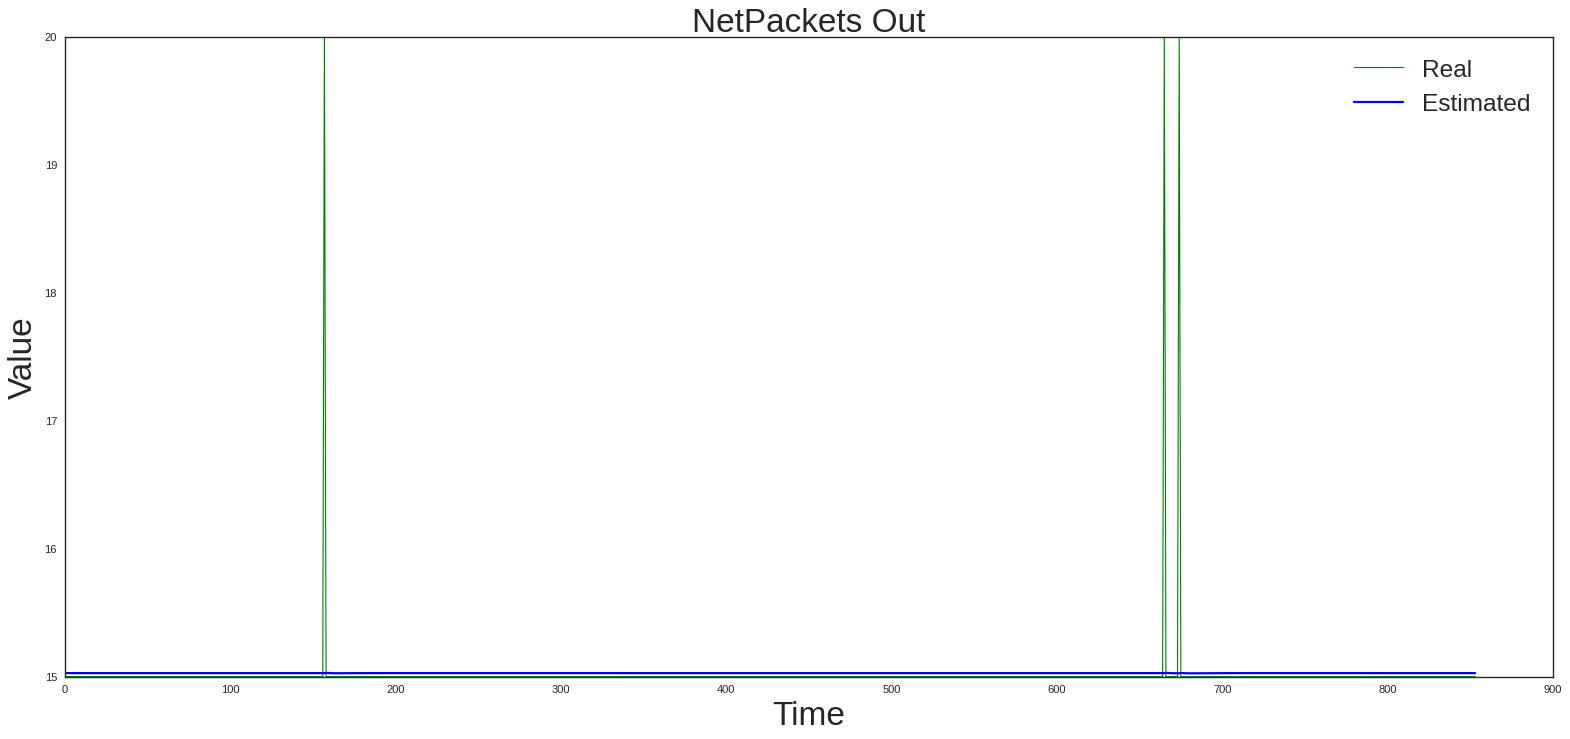

In [ ]:
plt.figure(figsize=(24, 10))
plt.subplot(1, 1, 1)
plt.plot(y_ts_ds[:, 0, index], color = 'green', linewidth=1.0, label='Real')
plt.plot(y_ts_predict[:, 0, index], color = 'blue', linewidth=2.0, label='Estimated')
plt.title(col, fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Value', fontsize=30)
plt.grid(False)
plt.legend(fontsize=22)
plt.savefig(f'{col.replace("/", "_")}_test_result.png')
plt.show()

In [ ]:
y_ts_predict[:, 0, index]

array([15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.027858 ,
       15.027858 , 15.027858 , 15.027858 , 15.027858 , 15.0278

In [ ]:
pd.DataFrame({'real': y_ts_ds[:, 0, 0], 'predict': y_ts_predict[:, 0, 0]}).to_csv(f'result_{col}.csv')